In [1]:
import numpy as np
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
from scipy import stats
from statistics import stdev
import datetime
from datetime import timedelta
from collections import Counter
#import cx_Oracle
import psycopg2
import seaborn as sns
import json
import pickle
#from fitter import Fitter
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
data = pd.read_pickle("./it_sp_orders_from_tiers_51-56.pkl")

In [3]:
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3775537 entries, 0 to 3840991
Data columns (total 26 columns):
SCM_N_ORDER_POS_NR              int64
SCM_N_ORDER_NR                  int64
TDT_T_KEY_ORDER_DATE            datetime64[ns]
THR_C_KEY_ORDER_HOUR            object
SIT_N_KEY_SITE                  int64
CUS_N_KEY_CUSTOMER              int64
SCM_SALES_BMF                   float64
SCM_D_FINANCE_CM1               float64
SCM_D_FINANCE_CM2               float64
SCM_D_ORIG_FINANCE_ORDER_NET    float64
SCM_AP_ID                       int64
SCM_AS_ID                       int64
SCM_MASTER_AP_ID                int64
OSP_KO_COUNT_NET                int64
OSP_3_LEAD_P_PG_ID              int64
OSP_3_LEAD_P_PG_SHARE           float64
OSP_4_LEAD_P_PG_ID              int64
OSP_4_LEAD_P_PG_SHARE           float64
CZP_START_DATE                  datetime64[ns]
CZP_EXPIRY_DATE                 datetime64[ns]
CZP_ZTQ_ID                      int64
CZP_PERCENTAGE                  int64
CZP_PRICE  

In [4]:
data.head()

,SCM_N_ORDER_POS_NR,SCM_N_ORDER_NR,TDT_T_KEY_ORDER_DATE,THR_C_KEY_ORDER_HOUR,SIT_N_KEY_SITE,CUS_N_KEY_CUSTOMER,SCM_SALES_BMF,SCM_D_FINANCE_CM1,SCM_D_FINANCE_CM2,SCM_D_ORIG_FINANCE_ORDER_NET,...,OSP_4_LEAD_P_PG_ID,OSP_4_LEAD_P_PG_SHARE,CZP_START_DATE,CZP_EXPIRY_DATE,CZP_ZTQ_ID,CZP_PERCENTAGE,CZP_PRICE,ORDER_DATETIME,WEEK_NUMBER,MONTH_NUMBER
0,407308546,95460477,2017-10-01,17:39,12,8408291,13.4395,3.6365,2.6887,11.0160,...,81397,0.2703,2017-02-11 16:55:00,2020-02-11 23:59:00,52,3,5.99,2017-10-01 17:39:00,39,10
1,407308548,95460477,2017-10-01,17:39,12,8408291,0.0000,-0.4300,-0.6192,0.0000,...,81397,0.2703,2017-02-11 16:55:00,2020-02-11 23:59:00,52,3,5.99,2017-10-01 17:39:00,39,10
2,407308546,95460477,2017-10-01,17:39,12,8408291,13.5505,3.6665,2.7109,11.1070,...,81397,0.2703,2017-02-11 16:55:00,2020-02-11 23:59:00,52,3,5.99,2017-10-01 17:39:00,39,10
3,407308551,95460477,2017-10-01,17:39,12,8408291,-4.4600,-3.6557,-3.6557,-3.6557,...,81397,0.2703,2017-02-11 16:55:00,2020-02-11 23:59:00,52,3,5.99,2017-10-01 17:39:00,39,10
4,407308547,95460477,2017-10-01,17:39,12,8408291,8.3800,0.8089,0.1009,6.8689,...,81397,0.2703,2017-02-11 16:55:00,2020-02-11 23:59:00,52,3,5.99,2017-10-01 17:39:00,39,10


In [5]:
data['FIRST_O_DATE'] = data['TDT_T_KEY_ORDER_DATE'].groupby(data['CUS_N_KEY_CUSTOMER']).transform('min')

In [6]:
data['LAST_O_DATE'] = data['TDT_T_KEY_ORDER_DATE'].groupby(data['CUS_N_KEY_CUSTOMER']).transform('max')

In [7]:
data['1ST_O_COUNTER'] = data['OSP_KO_COUNT_NET'].groupby(data['CUS_N_KEY_CUSTOMER']).transform('min')

In [8]:
data['D28'] = data['FIRST_O_DATE'] + timedelta(days = 28)
data['D56'] = data['FIRST_O_DATE'] + timedelta(days = 56)
data['D84'] = data['FIRST_O_DATE'] + timedelta(days = 84)
data['D168'] = data['FIRST_O_DATE'] + timedelta(days = 168)
data['D252'] = data['FIRST_O_DATE'] + timedelta(days = 252)
data['D336'] = data['FIRST_O_DATE'] + timedelta(days = 336)

In [9]:
data.columns

Index(['SCM_N_ORDER_POS_NR', 'SCM_N_ORDER_NR', 'TDT_T_KEY_ORDER_DATE',
       'THR_C_KEY_ORDER_HOUR', 'SIT_N_KEY_SITE', 'CUS_N_KEY_CUSTOMER',
       'SCM_SALES_BMF', 'SCM_D_FINANCE_CM1', 'SCM_D_FINANCE_CM2',
       'SCM_D_ORIG_FINANCE_ORDER_NET', 'SCM_AP_ID', 'SCM_AS_ID',
       'SCM_MASTER_AP_ID', 'OSP_KO_COUNT_NET', 'OSP_3_LEAD_P_PG_ID',
       'OSP_3_LEAD_P_PG_SHARE', 'OSP_4_LEAD_P_PG_ID', 'OSP_4_LEAD_P_PG_SHARE',
       'CZP_START_DATE', 'CZP_EXPIRY_DATE', 'CZP_ZTQ_ID', 'CZP_PERCENTAGE',
       'CZP_PRICE', 'ORDER_DATETIME', 'WEEK_NUMBER', 'MONTH_NUMBER',
       'FIRST_O_DATE', 'LAST_O_DATE', '1ST_O_COUNTER', 'D28', 'D56', 'D84',
       'D168', 'D252', 'D336'],
      dtype='object')

In [10]:
agg_ops = {'TDT_T_KEY_ORDER_DATE': min,
          'CUS_N_KEY_CUSTOMER': min,
          'CZP_ZTQ_ID': min, 
          'SCM_SALES_BMF': sum,
          'SCM_D_FINANCE_CM1': sum,
          'SCM_D_FINANCE_CM2': sum,
          'SCM_D_ORIG_FINANCE_ORDER_NET': sum,
          'OSP_KO_COUNT_NET': min,
          'CZP_START_DATE': min,
          'CZP_EXPIRY_DATE': min,
          'ORDER_DATETIME': min,
          'FIRST_O_DATE': min,
          'LAST_O_DATE': min,
          '1ST_O_COUNTER': min,
          'D28': min,
          'D56': min,
          'D84': min,
          'D168': min,
          'D252': min,
          'D336': min
          }

In [11]:
orders = data.groupby('SCM_N_ORDER_NR', as_index=False).agg(agg_ops)

In [12]:
data['SCM_N_ORDER_NR'].nunique(), len(orders)

(680828, 680828)

In [13]:
orders.tail()

,SCM_N_ORDER_NR,TDT_T_KEY_ORDER_DATE,CUS_N_KEY_CUSTOMER,CZP_ZTQ_ID,SCM_SALES_BMF,SCM_D_FINANCE_CM1,SCM_D_FINANCE_CM2,SCM_D_ORIG_FINANCE_ORDER_NET,OSP_KO_COUNT_NET,CZP_START_DATE,...,ORDER_DATETIME,FIRST_O_DATE,LAST_O_DATE,1ST_O_COUNTER,D28,D56,D84,D168,D252,D336
680823,120154101,2018-09-30,9016157,54,59.97,18.2057,10.2509,49.1557,73,2017-08-03 02:31:00,...,2018-09-30 23:54:00,2017-10-01,2018-09-30,56,2017-10-29,2017-11-26,2017-12-24,2018-03-18,2018-06-10,2018-09-02
680824,120154149,2018-09-30,6191608,52,213.37,63.2534,50.4698,174.8934,20,2018-04-29 00:00:00,...,2018-09-30 23:57:00,2018-01-27,2018-09-30,15,2018-02-24,2018-03-24,2018-04-21,2018-07-14,2018-10-06,2018-12-29
680825,120154185,2018-09-30,16655954,51,51.39,12.8430,4.7291,42.1230,23,2018-06-01 00:00:00,...,2018-09-30 23:53:00,2017-10-06,2018-09-30,10,2017-11-03,2017-12-01,2017-12-29,2018-03-23,2018-06-15,2018-09-07
680826,120154245,2018-09-30,12890111,54,189.99,49.6195,33.0219,155.7295,1910,2016-10-14 12:59:00,...,2018-09-30 23:55:00,2017-10-01,2018-09-30,1358,2017-10-29,2017-11-26,2017-12-24,2018-03-18,2018-06-10,2018-09-02
680827,120154377,2018-09-30,14584967,52,44.63,19.7319,9.0542,36.5819,7,2017-08-20 15:45:00,...,2018-09-30 23:59:00,2018-08-18,2018-09-30,5,2018-09-15,2018-10-13,2018-11-10,2019-02-02,2019-04-27,2019-07-20


In [14]:
orders['OK_28D'] = (orders['TDT_T_KEY_ORDER_DATE'] <= orders['D28']) * 1
orders['OK_56D'] = (orders['TDT_T_KEY_ORDER_DATE'] <= orders['D56']) * 1
orders['OK_84D'] = (orders['TDT_T_KEY_ORDER_DATE'] <= orders['D84']) * 1
orders['OK_168D'] = (orders['TDT_T_KEY_ORDER_DATE'] <= orders['D168']) * 1
orders['OK_252D'] = (orders['TDT_T_KEY_ORDER_DATE'] <= orders['D252']) * 1
orders['OK_336D'] = (orders['TDT_T_KEY_ORDER_DATE'] <= orders['D336']) * 1

In [15]:
orders['COUNTER_28D'] = orders['OK_28D'] * orders['OSP_KO_COUNT_NET']
orders['COUNTER_56D'] = orders['OK_56D'] * orders['OSP_KO_COUNT_NET']
orders['COUNTER_84D'] = orders['OK_84D'] * orders['OSP_KO_COUNT_NET']
orders['COUNTER_168D'] = orders['OK_168D'] * orders['OSP_KO_COUNT_NET']
orders['COUNTER_252D'] = orders['OK_252D'] * orders['OSP_KO_COUNT_NET']
orders['COUNTER_336D'] = orders['OK_336D'] * orders['OSP_KO_COUNT_NET']

In [16]:
orders['MAX_COUNTER_28D'] = orders['COUNTER_28D'].groupby(orders['CUS_N_KEY_CUSTOMER']).transform('max')
orders['MAX_COUNTER_56D'] = orders['COUNTER_56D'].groupby(orders['CUS_N_KEY_CUSTOMER']).transform('max')
orders['MAX_COUNTER_84D'] = orders['COUNTER_84D'].groupby(orders['CUS_N_KEY_CUSTOMER']).transform('max')
orders['MAX_COUNTER_168D'] = orders['COUNTER_168D'].groupby(orders['CUS_N_KEY_CUSTOMER']).transform('max')
orders['MAX_COUNTER_252D'] = orders['COUNTER_252D'].groupby(orders['CUS_N_KEY_CUSTOMER']).transform('max')
orders['MAX_COUNTER_336D'] = orders['COUNTER_336D'].groupby(orders['CUS_N_KEY_CUSTOMER']).transform('max')

In [17]:
orders['RR_28D'] = (orders['MAX_COUNTER_28D'] > orders['1ST_O_COUNTER']) * 1
orders['RR_56D'] = (orders['MAX_COUNTER_56D'] > orders['MAX_COUNTER_28D']) * 1
orders['RR_84D'] = (orders['MAX_COUNTER_84D'] > orders['MAX_COUNTER_56D']) * 1 
orders['RR_168D'] = (orders['MAX_COUNTER_168D'] > orders['MAX_COUNTER_84D']) * 1
orders['RR_252D'] = (orders['MAX_COUNTER_252D'] > orders['MAX_COUNTER_168D']) * 1 
orders['RR_336D'] = (orders['MAX_COUNTER_336D'] > orders['MAX_COUNTER_168D']) * 1

In [18]:
orders.columns

Index(['SCM_N_ORDER_NR', 'TDT_T_KEY_ORDER_DATE', 'CUS_N_KEY_CUSTOMER',
       'CZP_ZTQ_ID', 'SCM_SALES_BMF', 'SCM_D_FINANCE_CM1', 'SCM_D_FINANCE_CM2',
       'SCM_D_ORIG_FINANCE_ORDER_NET', 'OSP_KO_COUNT_NET', 'CZP_START_DATE',
       'CZP_EXPIRY_DATE', 'ORDER_DATETIME', 'FIRST_O_DATE', 'LAST_O_DATE',
       '1ST_O_COUNTER', 'D28', 'D56', 'D84', 'D168', 'D252', 'D336', 'OK_28D',
       'OK_56D', 'OK_84D', 'OK_168D', 'OK_252D', 'OK_336D', 'COUNTER_28D',
       'COUNTER_56D', 'COUNTER_84D', 'COUNTER_168D', 'COUNTER_252D',
       'COUNTER_336D', 'MAX_COUNTER_28D', 'MAX_COUNTER_56D', 'MAX_COUNTER_84D',
       'MAX_COUNTER_168D', 'MAX_COUNTER_252D', 'MAX_COUNTER_336D', 'RR_28D',
       'RR_56D', 'RR_84D', 'RR_168D', 'RR_252D', 'RR_336D'],
      dtype='object')

In [19]:
agg_ord_ops = {'CZP_ZTQ_ID': 'unique',
              'SCM_N_ORDER_NR': len,
              'SCM_SALES_BMF': [sum, lambda x: list(np.round(x, 2))],
              'SCM_D_FINANCE_CM1': [sum, lambda x: list(np.round(x, 2))],
              'SCM_D_FINANCE_CM2': [sum, lambda x: list(np.round(x, 2))],
              'SCM_D_ORIG_FINANCE_ORDER_NET': [sum, lambda x: list(np.round(x, 2))],
              'OSP_KO_COUNT_NET': lambda x: list(x),
              'CZP_START_DATE': 'unique',
              'CZP_EXPIRY_DATE': 'unique',
              'FIRST_O_DATE': min,
              'LAST_O_DATE': min,
              '1ST_O_COUNTER': min,
              'COUNTER_28D': max,
              'COUNTER_56D': max,
              'COUNTER_84D': max,
              'COUNTER_168D': max,
              'COUNTER_252D': max,
              'COUNTER_336D': max
              }

In [20]:
customers = orders.groupby('CUS_N_KEY_CUSTOMER', as_index=False).agg(agg_ord_ops).round(2)

In [21]:
customers.columns = ['_'.join(tup).rstrip('_') for tup in customers.columns.values]

In [22]:
customers.head()

,CUS_N_KEY_CUSTOMER,CZP_ZTQ_ID_unique,SCM_N_ORDER_NR_len,SCM_SALES_BMF_sum,SCM_SALES_BMF_<lambda>,SCM_D_FINANCE_CM1_sum,SCM_D_FINANCE_CM1_<lambda>,SCM_D_FINANCE_CM2_sum,SCM_D_FINANCE_CM2_<lambda>,SCM_D_ORIG_FINANCE_ORDER_NET_sum,...,CZP_EXPIRY_DATE_unique,FIRST_O_DATE_min,LAST_O_DATE_min,1ST_O_COUNTER_min,COUNTER_28D_max,COUNTER_56D_max,COUNTER_84D_max,COUNTER_168D_max,COUNTER_252D_max,COUNTER_336D_max
0,70860,[51],2,181.14,"[65.93, 115.21]",41.25,"[18.82, 22.42]",22.78,"[11.02, 11.75]",148.48,...,[2018-05-16T23:59:00.000000000],2017-12-01,2018-01-30,106,106,106,107,107,107,107
1,209948,[54],2,166.15,"[105.88, 60.27]",36.22,"[21.45, 14.77]",19.97,"[12.98, 6.98]",136.19,...,[2018-01-09T23:59:00.000000000],2017-11-10,2017-11-10,259,260,260,260,260,260,260
2,351905,"[51, 52]",10,1376.06,"[121.63, 189.05, 186.06, 123.52, 99.75, 138.61...",350.22,"[27.72, 42.67, 38.05, 34.63, 22.65, 41.69, 29....",224.50,"[19.24, 23.75, 28.58, 17.93, 13.23, 25.36, 18....",1130.95,...,"[2018-06-16T23:59:00.000000000, 2021-06-16T00:...",2017-10-20,2018-09-13,137,138,139,140,141,144,146
3,606724,[51],1,23.93,[23.93],9.57,[9.57],3.63,[3.63],19.61,...,[2019-03-08T23:59:00.000000000],2018-03-30,2018-03-30,19,19,19,19,19,19,19
4,616228,[51],5,228.73,"[62.98, 37.28, 34.41, 51.37, 42.69]",57.69,"[19.56, 7.44, 8.03, 14.95, 7.71]",15.57,"[5.24, 1.33, 1.11, 6.83, 1.05]",187.48,...,"[2018-05-02T23:59:00.000000000, 2019-07-02T00:...",2017-11-01,2018-07-19,115,115,117,117,117,118,119


In [23]:
customers['DIFF_DAYS'] = (customers['LAST_O_DATE_min'] - customers['FIRST_O_DATE_min']).dt.days

In [24]:
customers['SUIT_28D'] = ((customers['LAST_O_DATE_min'].max() - timedelta(days=28)) >= customers['FIRST_O_DATE_min']) * 1
customers['SUIT_56D'] = ((customers['LAST_O_DATE_min'].max() - timedelta(days=56)) >= customers['FIRST_O_DATE_min']) * 1
customers['SUIT_84D'] = ((customers['LAST_O_DATE_min'].max() - timedelta(days=84)) >= customers['FIRST_O_DATE_min']) * 1
customers['SUIT_168D'] = ((customers['LAST_O_DATE_min'].max() - timedelta(days=168)) >= customers['FIRST_O_DATE_min']) * 1
customers['SUIT_252D'] = ((customers['LAST_O_DATE_min'].max() - timedelta(days=252)) >= customers['FIRST_O_DATE_min']) * 1
customers['SUIT_336D'] = ((customers['LAST_O_DATE_min'].max() - timedelta(days=336)) >= customers['FIRST_O_DATE_min']) * 1

In [25]:
customers['R28D'] = (customers['COUNTER_28D_max'] > customers['1ST_O_COUNTER_min']) * 1
customers['R56D'] = (customers['COUNTER_56D_max'] > customers['COUNTER_28D_max']) * 1
customers['R84D'] = (customers['COUNTER_84D_max'] > customers['COUNTER_56D_max']) * 1
customers['R168D'] = (customers['COUNTER_168D_max'] > customers['COUNTER_84D_max']) * 1
customers['R252D'] = (customers['COUNTER_252D_max'] > customers['COUNTER_168D_max']) * 1
customers['R336D'] = (customers['COUNTER_336D_max'] > customers['COUNTER_252D_max']) * 1

In [26]:
customers['RR_28D'] = customers['R28D']
customers['RR_56D'] = customers['R56D'] | customers['RR_28D']
customers['RR_84D'] = customers['R84D'] | customers['RR_56D']
customers['RR_168D'] = customers['R168D'] | customers['RR_84D']
customers['RR_252D'] = customers['R252D'] | customers['RR_168D']
customers['RR_336D'] = customers['R336D'] | customers['RR_252D']

In [27]:
customers['R_28D'] = customers['RR_28D'] * customers['SUIT_28D']
customers['R_56D'] = customers['RR_56D'] * customers['SUIT_56D']
customers['R_84D'] = customers['RR_84D'] * customers['SUIT_84D']
customers['R_168D'] = customers['RR_168D']  * customers['SUIT_168D']
customers['R_252D'] = customers['RR_252D'] * customers['SUIT_252D']
customers['R_336D'] = customers['RR_336D'] * customers['SUIT_336D']

In [28]:
customers.to_pickle("./test_local_it_sp_customers_tiers_51-56.pkl")

In [29]:
mask = [len(i) == 1 for i in customers['CZP_ZTQ_ID_unique'].values]

In [30]:
sp_customers = customers[mask]

In [31]:
def get_number_from_string(i):
    changes = str(i).replace('[', '').replace(']', '')
    return int(changes)

In [32]:
t_customers = sp_customers.copy()

In [33]:
t_customers['CZP_ZTQ_ID_unique'] = t_customers['CZP_ZTQ_ID_unique'].map(get_number_from_string)

In [34]:
t_customers['CZP_ZTQ_ID_unique'].value_counts()

51    34198
56    24366
52    18876
53    16518
54    13588
55     3699
Name: CZP_ZTQ_ID_unique, dtype: int64

In [35]:
tier_rr_28d = (t_customers.groupby('CZP_ZTQ_ID_unique')['R_28D'].sum() / t_customers.groupby('CZP_ZTQ_ID_unique')['SUIT_28D'].sum() * 100).round(2)
tier_rr_56d = (t_customers.groupby('CZP_ZTQ_ID_unique')['R_56D'].sum() / t_customers.groupby('CZP_ZTQ_ID_unique')['SUIT_56D'].sum() * 100).round(2)
tier_rr_84d = (t_customers.groupby('CZP_ZTQ_ID_unique')['R_84D'].sum() / t_customers.groupby('CZP_ZTQ_ID_unique')['SUIT_84D'].sum() * 100).round(2)
tier_rr_168d = (t_customers.groupby('CZP_ZTQ_ID_unique')['R_168D'].sum() / t_customers.groupby('CZP_ZTQ_ID_unique')['SUIT_168D'].sum() * 100).round(2)
tier_rr_252d = (t_customers.groupby('CZP_ZTQ_ID_unique')['R_252D'].sum() / t_customers.groupby('CZP_ZTQ_ID_unique')['SUIT_252D'].sum() * 100).round(2)
tier_rr_336d = (t_customers.groupby('CZP_ZTQ_ID_unique')['R_336D'].sum() / t_customers.groupby('CZP_ZTQ_ID_unique')['SUIT_336D'].sum() * 100).round(2)

In [36]:
rep_rate_tiers = pd.DataFrame([tier_rr_28d, tier_rr_56d, tier_rr_84d, tier_rr_168d, tier_rr_252d, tier_rr_336d]).T
rep_rate_tiers.columns = ['28d', '56d', '84d', '168d', '252d', '336d']
rep_rate_tiers

,28d,56d,84d,168d,252d,336d
CZP_ZTQ_ID_unique,,,,,,
51,22.91,52.38,69.02,84.90,89.75,94.02
52,22.94,51.32,67.94,86.89,93.09,96.62
53,23.04,50.38,66.41,83.23,88.68,93.42
54,25.04,52.24,68.77,88.31,94.16,97.39
55,21.23,44.34,56.83,68.83,71.79,73.44
56,23.62,49.70,63.24,75.51,78.59,82.64


In [37]:
ztq = [51, 52, 53, 54, 55, 56]

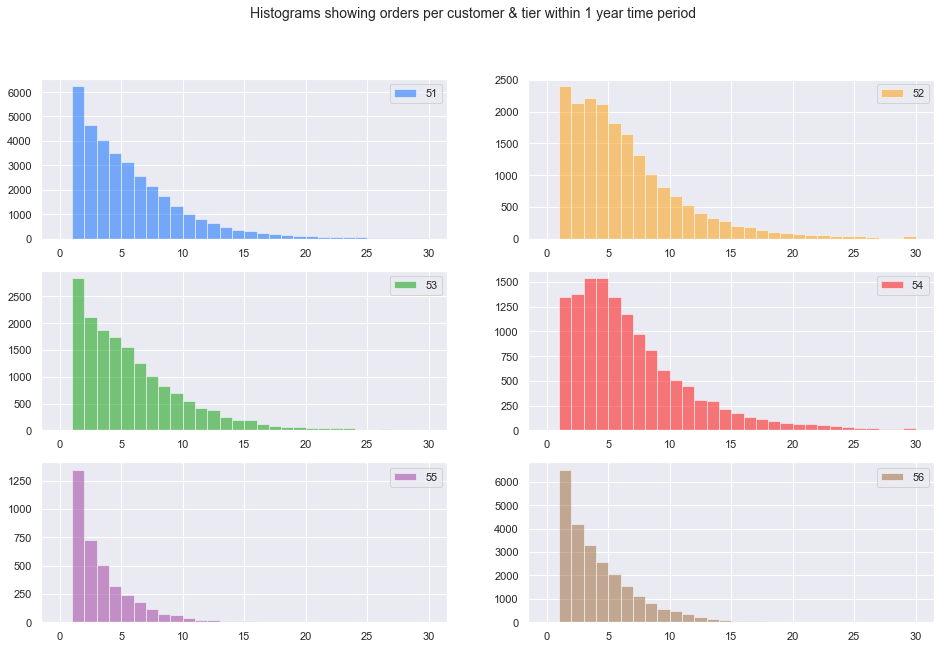

,Tier 51 ORDERS,Tier 52 ORDERS,Tier 53 ORDERS,Tier 54 ORDERS,Tier 55 ORDERS,Tier 56 ORDERS
count,34198.00,18876.00,16518.00,13588.00,3699.00,24366.00
mean,5.37,6.11,5.59,6.77,3.10,4.13
std,5.03,5.33,5.06,7.58,2.76,21.93
min,1.00,1.00,1.00,1.00,1.00,1.00
25%,2.00,3.00,2.00,3.00,1.00,1.00
50%,4.00,5.00,4.00,5.00,2.00,3.00
75%,7.00,8.00,8.00,9.00,4.00,5.00
max,151.00,119.00,141.00,475.00,25.00,3226.00


In [38]:
sns.set()
plt.figure(figsize=(16,10))
plt.suptitle('Histograms showing orders per customer & tier within 1 year time period', fontsize=14)
plt.subplot(321)
data_tier_51 = t_customers[t_customers['CZP_ZTQ_ID_unique'] == 51]
data_tier_51['SCM_N_ORDER_NR_len'].hist(bins=30, range=(0, 30), color='#0066ff', alpha=0.5)
plt.legend([51])
plt.subplot(322)
data_tier_52 = t_customers[t_customers['CZP_ZTQ_ID_unique'] == 52]
data_tier_52['SCM_N_ORDER_NR_len'].hist(bins=30, range=(0, 30), color='#ff9900', alpha=0.5)
plt.legend([52])
plt.subplot(323)
data_tier_53 = t_customers[t_customers['CZP_ZTQ_ID_unique'] == 53]
data_tier_53['SCM_N_ORDER_NR_len'].hist(bins=30, range=(0, 30), color='#009900', alpha=0.5)
plt.legend([53])
plt.subplot(324)
data_tier_54 = t_customers[t_customers['CZP_ZTQ_ID_unique'] == 54]
data_tier_54['SCM_N_ORDER_NR_len'].hist(bins=30, range=(0, 30), color='#ff0000', alpha=0.5)
plt.legend([54])
plt.subplot(325)
data_tier_55 = t_customers[t_customers['CZP_ZTQ_ID_unique'] == 55]
data_tier_55['SCM_N_ORDER_NR_len'].hist(bins=30, range=(0, 30), color='#993399', alpha=0.5)
plt.legend([55])
plt.subplot(326)
data_tier_56 = t_customers[t_customers['CZP_ZTQ_ID_unique'] == 56]
data_tier_56['SCM_N_ORDER_NR_len'].hist(bins=30, range=(0, 30), color='#996633', alpha=0.5)
plt.legend([56])
plt.show() 

concat_df = pd.DataFrame()
for tq in ztq:
    data_tier = t_customers[t_customers['CZP_ZTQ_ID_unique'] == tq]
    concat_df = pd.concat([concat_df,
                           pd.DataFrame(data_tier['SCM_N_ORDER_NR_len'].describe().round(2)),
                           ], axis=1)
concat_df.columns = ['Tier 51 ORDERS', 'Tier 52 ORDERS', 'Tier 53 ORDERS',
                     'Tier 54 ORDERS', 'Tier 55 ORDERS', 'Tier 56 ORDERS']
display(concat_df)

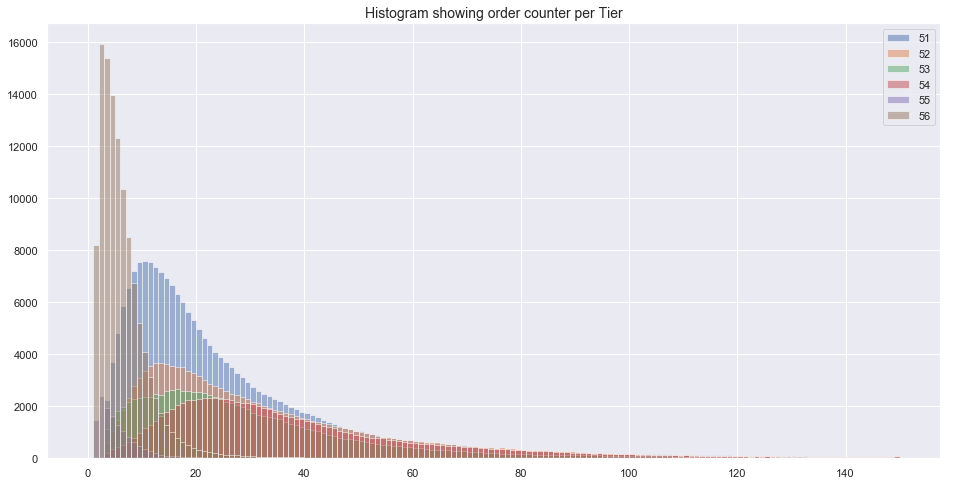

,Tier 51 Order_Counter,Tier 52 Order_Counter,Tier 53 Order_Counter,Tier 54 Order_Counter,Tier 55 Order_Counter,Tier 56 Order_Counter
count,209129.00,136312.00,100373.00,101345.00,13182.00,120487.00
mean,29.11,37.16,31.54,55.08,5.14,66.43
std,30.70,49.19,30.58,130.70,4.82,360.34
min,1.00,2.00,1.00,1.00,1.00,1.00
25%,11.00,15.00,14.00,21.00,2.00,3.00
50%,20.00,27.00,24.00,33.00,4.00,5.00
75%,35.00,46.00,39.00,53.00,7.00,8.00
max,493.00,4056.00,554.00,3251.00,106.00,4376.00


In [39]:
concat_df = pd.DataFrame()
sns.set()
plt.figure(figsize=(16,8))
plt.title('Histogram showing order counter per Tier', fontsize=14)

for tq in ztq:
    data_tier = orders[orders['CZP_ZTQ_ID'] == tq]
    order_counter_values = [i for i in data_tier['OSP_KO_COUNT_NET'].values]
    plt.hist(order_counter_values, bins=150, range=(0, 150), alpha=0.5)
    plt.legend([51, 52, 53, 54, 55, 56])
    concat_df = pd.concat([concat_df,
                           (pd.DataFrame(order_counter_values).describe().round(2)),
                           ], axis=1)
plt.show() 

concat_df.columns = ['Tier 51 Order_Counter', 'Tier 52 Order_Counter', 'Tier 53 Order_Counter',
                     'Tier 54 Order_Counter', 'Tier 55 Order_Counter', 'Tier 56 Order_Counter']
display(concat_df)

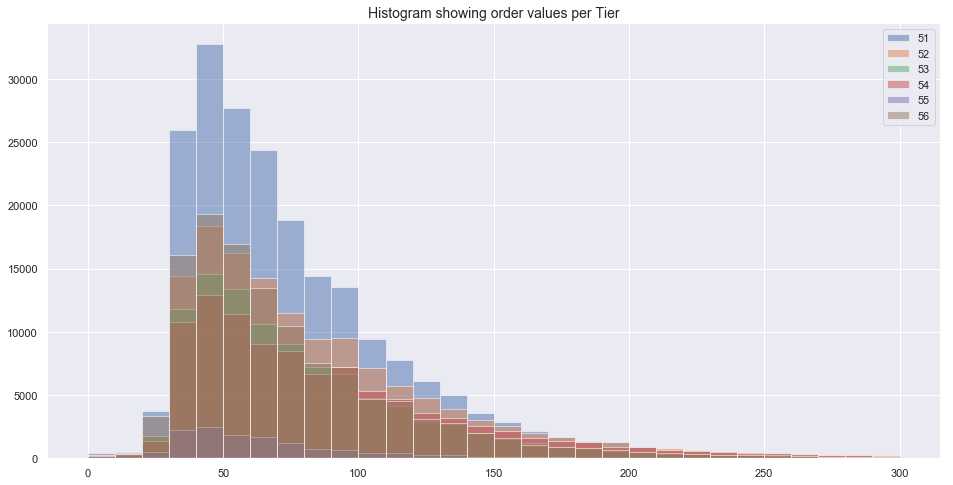

,Tier 51 Order_Values,Tier 52 Order_Values,Tier 53 Order_Values,Tier 54 Order_Values,Tier 55 Order_Values,Tier 56 Order_Values
count,209129.00,136312.00,100373.00,101345.00,13182.00,120487.00
mean,78.46,88.46,81.38,92.89,66.95,76.77
std,49.25,60.87,53.57,68.79,37.19,51.36
min,-70.57,-39.55,-31.07,-33.60,-14.60,-26.82
25%,46.55,48.94,47.49,49.38,41.78,45.58
50%,65.66,71.81,67.00,75.03,57.18,62.81
75%,96.01,107.71,99.34,113.97,79.51,93.08
max,1923.53,2073.63,2118.19,3019.01,570.30,2549.39


In [40]:
concat_df = pd.DataFrame()
sns.set()
plt.figure(figsize=(16,8))
plt.title('Histogram showing order values per Tier', fontsize=14)

for tq in ztq:
    data_tier = orders[orders['CZP_ZTQ_ID'] == tq]
    order_values = [i for i in data_tier['SCM_SALES_BMF'].values]
    plt.hist(order_values, bins=30, range=(0, 300), alpha=0.5)
    plt.legend([51, 52, 53, 54, 55, 56])
    concat_df = pd.concat([concat_df,
                           (pd.DataFrame(order_values).describe().round(2)),
                           ], axis=1)
plt.show() 

concat_df.columns = ['Tier 51 Order_Values', 'Tier 52 Order_Values', 'Tier 53 Order_Values',
                     'Tier 54 Order_Values', 'Tier 55 Order_Values', 'Tier 56 Order_Values']
display(concat_df)

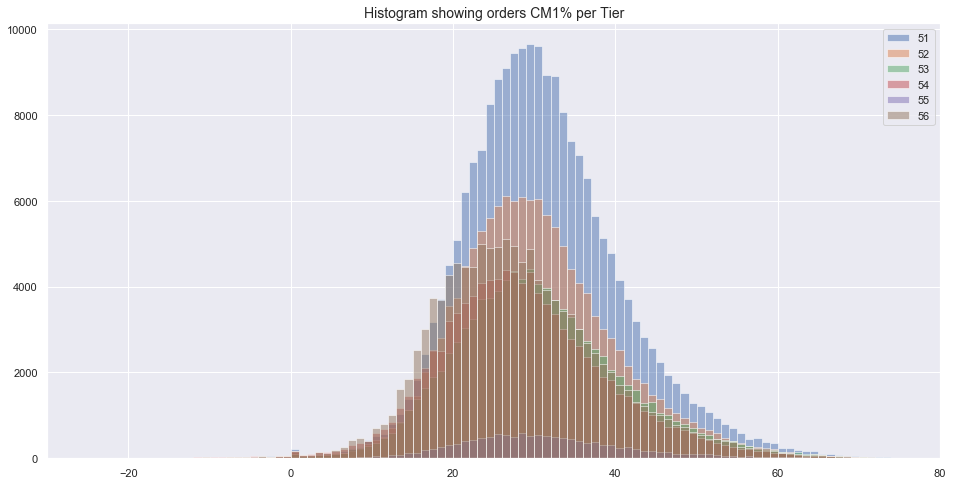

,Tier 51 Order_CM1%,Tier 52 Order_CM1%,Tier 53 Order_CM1%,Tier 54 Order_CM1%,Tier 55 Order_CM1%,Tier 56 Order_CM1%
count,209109.00,136297.00,100363.00,101327.00,13180.00,120465.00
25%,24.54,23.53,23.42,21.53,24.05,20.87
50%,30.19,29.32,29.56,27.72,30.16,27.10
75%,36.61,35.87,36.68,34.66,37.40,34.32


In [41]:
concat_df = pd.DataFrame()
sns.set()
plt.figure(figsize=(16,8))
plt.title('Histogram showing orders CM1% per Tier', fontsize=14)

for tq in ztq:
    data_tier = orders[orders['CZP_ZTQ_ID'] == tq]
    order_values_cm1 = [i for i in data_tier['SCM_D_FINANCE_CM1'].values]
    order_values_net_sales = [i for i in data_tier['SCM_D_ORIG_FINANCE_ORDER_NET'].values]
    orders_rel_cm1 = [i/j * 100 for i, j in list(zip(order_values_cm1, order_values_net_sales)) if j != 0]
    plt.hist(orders_rel_cm1, bins=100, range=(-25, 75), alpha=0.5)
    plt.legend([51, 52, 53, 54, 55, 56])
    concat_df = pd.concat([concat_df,
                           (pd.DataFrame(orders_rel_cm1).describe().round(2)),
                           ], axis=1)

plt.legend([51, 52, 53, 54, 55, 56])
plt.show() 

concat_df.columns = ['Tier 51 Order_CM1%', 'Tier 52 Order_CM1%', 'Tier 53 Order_CM1%',
                     'Tier 54 Order_CM1%', 'Tier 55 Order_CM1%', 'Tier 56 Order_CM1%']
display(concat_df.loc[['count', '25%', '50%', '75%']].astype(float))

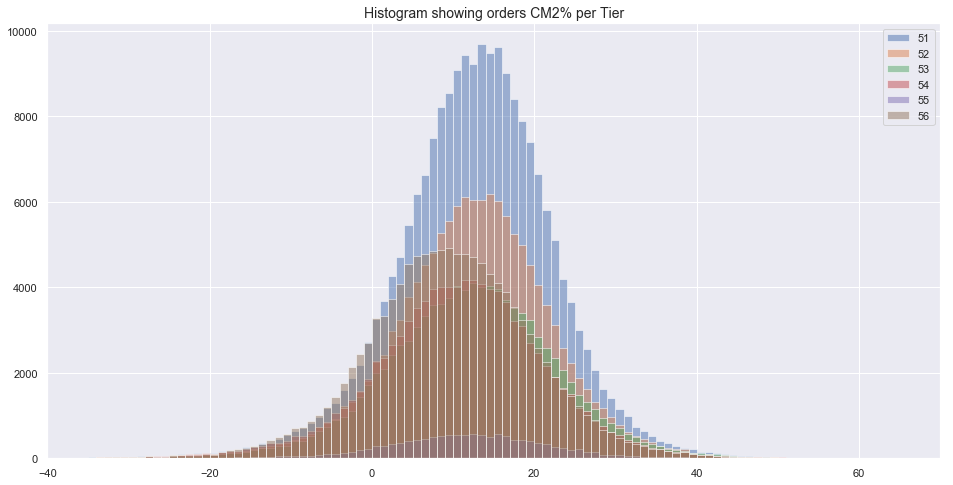

,Tier 51 Order_CM2%,Tier 52 Order_CM2%,Tier 53 Order_CM2%,Tier 54 Order_CM2%,Tier 55 Order_CM2%,Tier 56 Order_CM2%
count,209109.00,136297.00,100363.00,101327.00,13180.00,120465.00
25%,6.96,6.45,5.56,4.31,5.41,3.15
50%,13.00,12.66,12.35,10.97,11.85,9.58
75%,18.76,18.55,18.97,17.40,18.17,16.23


In [42]:
concat_df = pd.DataFrame()
sns.set()
plt.figure(figsize=(16,8))
plt.title('Histogram showing orders CM2% per Tier', fontsize=14)

for tq in ztq:
    data_tier = orders[orders['CZP_ZTQ_ID'] == tq]
    order_values_cm2 = [i for i in data_tier['SCM_D_FINANCE_CM2'].values]
    order_values_net_sales = [i for i in data_tier['SCM_D_ORIG_FINANCE_ORDER_NET'].values]
    orders_rel_cm2 = [i/j * 100 for i, j in list(zip(order_values_cm2, order_values_net_sales)) if j != 0]
    plt.hist(orders_rel_cm2, bins=100, range=(-35, 65), alpha=0.5)
    plt.legend([51, 52, 53, 54, 55, 56])
    concat_df = pd.concat([concat_df,
                           (pd.DataFrame(orders_rel_cm2).describe().round(2)),
                           ], axis=1)

plt.legend([51, 52, 53, 54, 55, 56])
plt.show() 

concat_df.columns = ['Tier 51 Order_CM2%', 'Tier 52 Order_CM2%', 'Tier 53 Order_CM2%',
                     'Tier 54 Order_CM2%', 'Tier 55 Order_CM2%', 'Tier 56 Order_CM2%']
display(concat_df.loc[['count', '25%', '50%', '75%']].astype(float))

In [43]:
metrics_ztq = pd.DataFrame(columns=['ZTQ','active_customers', 'orders', 'sales_bmf', 'net_sales', 'CM1', 'CM2', 'CM1%', 'CM2%',
                                   'discount_amount', 'orders_%_neg_cm1', 'loss_in_CM1', 'orders_%_neg_cm2', 'loss_in_CM2'])
for tq in ztq:
    df_elems = []
    data_tier = data[data['CZP_ZTQ_ID'] == tq]
    df_elems.append(tq)
    df_elems.append(data_tier['CUS_N_KEY_CUSTOMER'].nunique())
    df_elems.append(data_tier['SCM_N_ORDER_NR'].nunique())
    df_elems.append(data_tier['SCM_SALES_BMF'].sum())
    df_elems.append(data_tier['SCM_D_ORIG_FINANCE_ORDER_NET'].sum())
    df_elems.append(data_tier['SCM_D_FINANCE_CM1'].sum())
    df_elems.append(data_tier['SCM_D_FINANCE_CM2'].sum())
    df_elems.append(data_tier['SCM_D_FINANCE_CM1'].sum() / data_tier['SCM_D_ORIG_FINANCE_ORDER_NET'].sum() * 100)
    df_elems.append(data_tier['SCM_D_FINANCE_CM2'].sum() / data_tier['SCM_D_ORIG_FINANCE_ORDER_NET'].sum() * 100)
    df_elems.append((data_tier[data_tier['SCM_MASTER_AP_ID'] == 42715]['SCM_SALES_BMF']).sum())
    
    cm1_per_order = data_tier.groupby('SCM_N_ORDER_NR')['SCM_D_FINANCE_CM1'].sum()
    orders_neg_cm1 = cm1_per_order[cm1_per_order < 0].index.values
    df_elems.append(len(orders_neg_cm1)/data_tier['SCM_N_ORDER_NR'].nunique()*100)
    df_elems.append(cm1_per_order[cm1_per_order < 0].sum())
    
    cm2_per_order = data_tier.groupby('SCM_N_ORDER_NR')['SCM_D_FINANCE_CM2'].sum()
    orders_neg_cm2 = cm2_per_order[cm2_per_order < 0].index.values
    df_elems.append(len(orders_neg_cm2)/data_tier['SCM_N_ORDER_NR'].nunique()*100)
    df_elems.append(cm2_per_order[cm2_per_order < 0].sum())
    
    new_row = pd.DataFrame.from_records([df_elems], columns=metrics_ztq.columns)
    metrics_ztq = metrics_ztq.append(new_row, ignore_index=True)
    
display(metrics_ztq.round(2))

,ZTQ,active_customers,orders,sales_bmf,net_sales,CM1,CM2,CM1%,CM2%,discount_amount,orders_%_neg_cm1,loss_in_CM1,orders_%_neg_cm2,loss_in_CM2
0,51,40767,209129,16407504.76,13493429.89,4031396.51,1861475.41,29.88,13.80,-503639.77,0.56,-9010.39,8.99,-57945.85
1,52,23768,136312,12057897.83,9921503.40,2881504.34,1348974.01,29.04,13.60,-373420.54,0.79,-10762.07,9.95,-50138.60
2,53,18617,100373,8167863.06,6728207.34,1989596.90,910765.99,29.57,13.54,-427394.69,0.71,-4797.46,11.68,-35557.62
3,54,15422,101345,9413781.65,7752564.22,2131559.78,942514.80,27.49,12.16,-497554.21,1.18,-11364.20,14.33,-58013.10
4,55,4150,13182,882587.10,725549.97,216315.35,90907.73,29.81,12.53,-26889.98,0.59,-777.08,11.27,-4362.62
5,56,29257,120487,9249914.47,7605770.47,2056634.99,822173.09,27.04,10.81,-483110.52,0.83,-7863.03,16.13,-59361.85
